# Functions to run likelihood tests of certain parameters

In [1]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())

sys.path.append("./python3/") 
from main import HMM_Full
from plot.plot_posterior import plot_posterior, plot_posterior_panel

compute-a-16-99.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK


In [2]:
def plot_ll_curve(x, lls, color="maroon", lw=2, figsize=(4,4)):
    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.plot(jrts, lls,"o-", color=color, lw=lw)
    ax.set_xscale("linear")
    ax.set_xlabel("Jump Rate IBD state [per Morgan]")
    ax.set_ylabel("Log Likelihood")
    plt.show()
    
def run_ll_jrts(jrts, iid1="", iid2="", 
                ibd_in=1e4, ibd_out=1e-4, ch=3):
    """Get Log Likelihoods for jrts.
    jrts: Array
    return array of same size with log likelihoods"""
    h = HMM_Full(folder_in="./data/hdf5/1240k_v43/ch", l_model="hdf5", t_model="standard", 
                     e_model="haploid_gl", h_model = "FiveStateFast",
                     output=False, load=True)
    lls = np.zeros(len(jrts),dtype="float") # Create lls

    for i,jrt in enumerate(jrts):
        h.t_obj.set_params(ibd_in = ibd_in, ibd_out = ibd_out, ibd_jump = jrt)
        h.l_obj.set_params(iids=[iid1, iid2], ch=ch)
        _, _, _, _, tot_ll = h.run_fwd_bwd()
        lls[i] = tot_ll
    return lls

### Run Single LL Example [show]

In [117]:
%%time
jrts = np.logspace(2, 3.5, num=30)
iid1, iid2 = "I3949.DG", "I3950.DG"

lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                  ch=3, ibd_in=1e4, ibd_out=1e-4)

CPU times: user 14.6 s, sys: 420 ms, total: 15 s
Wall time: 16.1 s


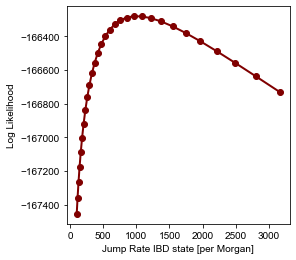

In [118]:
plot_ll_curve(jrts, lls)

# Load table of all parent offspring

In [3]:
m_o_homo=0.0025
frac_snps_good=0.75
savepath="./output/relatives_snp/po_high_quality.tsv"

df = pd.read_csv("./output/relatives_snp/po_full_all_ch.tsv", sep="\t")
df1 = df[df["relatedness"]=="Parent Offspring"].copy()
df2 = df1[df1["max_opp_homo_ch"]<m_o_homo].copy()
df_po = df2[df2["frac_snps_good_ch3"]>frac_snps_good].copy()
#df3 = df2[df2["opp_homo_rate_ch3"]<m_o_homo].copy()
print(f"Loaded {len(df1)} PO relationships")
print(f"Filtered to {len(df2)} with max. o. hommo rate {m_o_homo}")
print(f"Filtered to {len(df_po)} with {frac_snps_good} good SNP frac")

df_po.to_csv(savepath, sep="\t")
df_po = df_po.reset_index(drop=True)
print(f"Saved {len(df_po)} HQ Parent Offspring to {savepath}")

Loaded 333 PO relationships
Filtered to 305 with max. o. hommo rate 0.0025
Filtered to 220 with 0.75 good SNP frac
Saved 220 HQ Parent Offspring to ./output/relatives_snp/po_high_quality.tsv


### Minor Quality Check

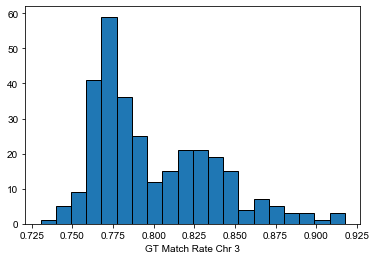

In [5]:
plt.figure()
ax=plt.gca()
ax.hist(df2["gt_match_rate_ch3"],ec="k", bins=20)
ax.set_xlabel("GT Match Rate Chr 3")
plt.show()

# Run single parent offspring [test]

In [ ]:
%%time
ch=1
jrts = np.logspace(2, 3.5, num=30)
lls_mat = np.zeros((len(df_po), len(jrts)))

for i in range(len(df_po[:])):
    print(f"Running Individual {i}")
    iid1, iid2 = df_po["iid1"][i], df_po["iid2"][i]
    lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                      ch=ch, ibd_in=1e4, ibd_out=1e-4)
    lls_mat[i] = lls

Running Individual 0
Running Individual 1


In [ ]:
### Save the Jump Rate LL Matrix
savepath="./output/jumprate_ll/ll_mat_po_hq_ch1.tsv"
np.savetxt(savepath, lls_mat, delimiter="\t")
print(f"Successfully saved {len(lls_mat)} Likelihood Curves to {savepath}")

# Load the Likelihood Curves and plot them [standalone from here]

In [10]:
def get_ci(jrts, l, level=2):
    """Get confidence intervall for jump rates based on
    array of likelihood l"""
    idcs_m = np.argmax(l)
    m = np.max(l)
    p = l >= (m - level)
    idx_g = np.where(p)[0]
    assert(len(idx_g)>0)  # Sanity Check

    m = jrts[idcs_m]
    l,u = jrts[idx_g[0]], jrts[idx_g[-1]]
    return m,l,u

def get_df_estimates(l1, df_po):
    """Merge Estimates from LL Jumprate inference in data frame"""
    ls, ms, us = np.zeros(len(l1)), np.zeros(len(l1)), np.zeros(len(l1))
    for i,l in enumerate(l1):
        ms[i], ls[i], us[i] = get_ci(jrts, l)
    df = df_po.copy()
    df["jrt_l"] = ls
    df["jrt_m"] = ms
    df["jrt_u"] = us
    df["shotgun"] = df["iid1"].str.contains(".DG|.SG") | df["iid2"].str.contains(".DG|.SG")    
    return df

In [7]:
jrts = np.logspace(2, 3.5, num=30)  ### HARD CODED
savepath3="./output/jumprate_ll/ll_mat_po_hq.tsv"
savepath1="./output/jumprate_ll/ll_mat_po_hq_ch1.tsv"

l3 = np.loadtxt(savepath3, delimiter="\t")
l1 = np.loadtxt(savepath1, delimiter="\t")

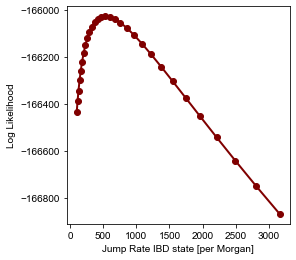

In [8]:
plot_ll_curve(jrts, l3[-1])  ### Test if load worked

## Check Jump Rate Inference against each other

In [9]:
m1 = jrts[np.argmax(l1, axis=1)]
m3 = jrts[np.argmax(l3, axis=1)]

Saved figure to ./figs/jumprates_ll/chr1_chr3.png


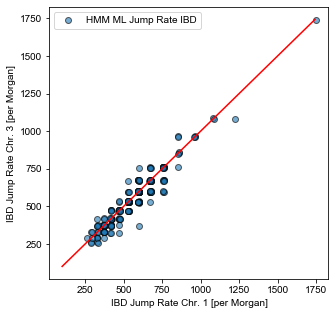

In [143]:
savepath="./figs/jumprates_ll/chr1_chr3.png"

plt.figure(figsize=(5,5))
ax=plt.gca()
e1 = 10*(np.random.random(len(m1))-0.5)
e2 = 10*(np.random.random(len(m3))-0.5)
ax.scatter(m1+e1, m3+e2, alpha=0.6, ec="k", label="HMM ML Jump Rate IBD")
ax.plot([100,np.max(m1)], [100,np.max(m3)], c="r")
ax.legend(loc="upper left")
ax.set_xlabel("IBD Jump Rate Chr. 1 [per Morgan]")
ax.set_ylabel("IBD Jump Rate Chr. 3 [per Morgan]")

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
    print(f"Saved figure to {savepath}")

plt.show()

In [32]:
df = get_df_estimates(l1+l3, df_po)
df1 = df[["jrt_l", "jrt_m", "jrt_u", "iid1", "iid2", "age1", "age2", 
          "n_cov_snp1", "n_cov_snp2", 'clst1', 'clst2', "study1", "study2",
          "frac_snps_good_ch3", "shotgun"]]
df1 = df1.sort_values(by="jrt_m").copy()

savepath = "./output/tables/ml_ibd_jumprates_PO.tsv"
df1.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df1)} PO LL values to {savepath}")
df1["color"] = ["coral" if i else "gray" for i in df1["shotgun"]]

Saved 220 PO LL values to ./output/tables/ml_ibd_jumprates_PO.tsv


### Plot against SNPs imputed

Saved figure to ./figs/jumprates_ll/jumprates_vrs_good_snpnr.png


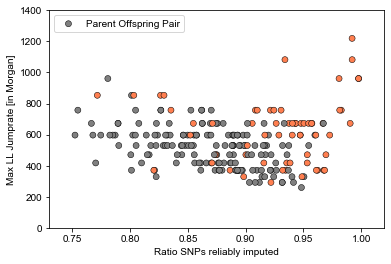

In [33]:
savepath="./figs/jumprates_ll/jumprates_vrs_good_snpnr.png"

plt.figure()
ax=plt.gca()
ax.scatter(df1["frac_snps_good_ch3"], df1["jrt_m"], c=df1["color"], ec="k", lw=0.5, label="Parent Offspring Pair")
ax.set_xlabel("Ratio SNPs reliably imputed")
ax.set_ylabel("Max LL Jumprate [in Morgan]")
ax.legend(loc="upper left")
ax.set_ylim([0,1400])

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
    print(f"Saved figure to {savepath}")

plt.show()

Saved figure to ./figs/jumprates_ll/jumprates_vrs_age.png


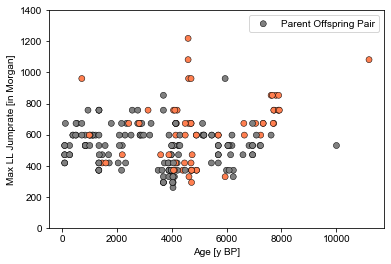

In [145]:
plt.figure()
ax=plt.gca()
ax.scatter(df1["age1"], df1["jrt_m"], c=df1["color"], ec="k", lw=0.5, label="Parent Offspring Pair")
ax.set_xlabel("Age [y BP]")
ax.set_ylabel("Max LL Jumprate [in Morgan]")
ax.legend(loc="upper right")
ax.set_ylim([0,1400])

savepath="./figs/jumprates_ll/jumprates_vrs_age.png"
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
    print(f"Saved figure to {savepath}")

plt.show()

# Do all of the individuals at once

### Quick and dirty histogram of ML Jump Rates

In [12]:
idcs = np.argmax(l1+l3, axis=1)

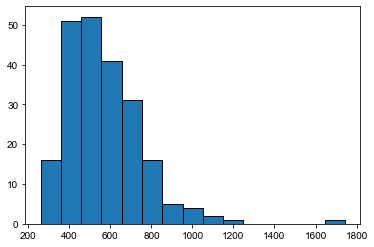

In [13]:
plt.figure()
ax=plt.gca()
ax.hist(jrts[idcs], ec="k", bins=15)
plt.show()

### Check joint likelihood of all indiviuals

In [20]:
l_t = l1 + l3
l_full = np.sum(l_t, axis=0)

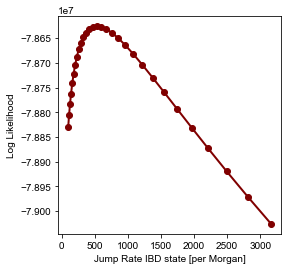

In [21]:
plot_ll_curve(jrts, l_full)  ### Test if load worked

In [24]:
i = np.argmax(l_full)
print(f"Maximum Likelihood at: {jrts[i]:.4f}")

Maximum Likelihood at: 529.8317


# Area 51

In [152]:
i=219
print(f"Running Individual {i}")
iid1, iid2 = df_po["iid1"][i], df_po["iid2"][i]
lls = run_ll_jrts(jrts, iid1=iid1, iid2=iid2, 
                      ch=ch, ibd_in=1e4, ibd_out=1e-4)
lls_mat[i] = lls

Running Individual 219


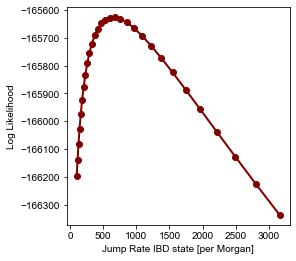

In [153]:
plot_ll_curve(jrts, lls)

In [34]:
df1[df1["iid1"].str.contains("SUC")]

,jrt_l,jrt_m,jrt_u,iid1,iid2,age1,age2,n_cov_snp1,n_cov_snp2,clst1,clst2,study1,study2,frac_snps_good_ch3,shotgun,color
15,529.831691,529.831691,529.831691,SUC002,SUC003,4072.0,3984.0,694993,741940,Italy_Sardinia_EBA_Nuragic_mother.SUC003,Italy_Sardinia_EBA,MarcusNatureCommunications2020,MarcusNatureCommunications2020,0.822305,False,gray
